In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_roi_t1t2_normalized_k5_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 276)
(734160, 1)
validation
(101248, 276)
(101248, 1)
test
(100432, 276)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 276)]             0         


 dense (Dense)               (None, 1024)              283648    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 972801 (3.71 MB)


Trainable params: 972801 (3.71 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:21 - loss: 0.0368 - STD: 8.1121e-05 - MAE: 0.1833

 6/74 [=>............................] - ETA: 0s - loss: 0.0246 - STD: 5.9782e-05 - MAE: 0.1148  

11/74 [===>..........................] - ETA: 0s - loss: 0.0202 - STD: 8.1310e-05 - MAE: 0.1050

16/74 [=====>........................] - ETA: 0s - loss: 0.0180 - STD: 1.0210e-04 - MAE: 0.0963

21/74 [=======>......................] - ETA: 0s - loss: 0.0170 - STD: 1.1874e-04 - MAE: 0.0882

26/74 [=========>....................] - ETA: 0s - loss: 0.0161 - STD: 1.4045e-04 - MAE: 0.0864

31/74 [===========>..................] - ETA: 0s - loss: 0.0155 - STD: 1.6118e-04 - MAE: 0.0846

36/74 [=============>................] - ETA: 0s - loss: 0.0150 - STD: 1.7983e-04 - MAE: 0.0814

41/74 [===============>..............] - ETA: 0s - loss: 0.0146 - STD: 2.0125e-04 - MAE: 0.0803

46/74 [=================>............] - ETA: 0s - loss: 0.0144 - STD: 2.2367e-04 - MAE: 0.0794

51/74 [===================>..........] - ETA: 0s - loss: 0.0142 - STD: 2.4714e-04 - MAE: 0.0781

54/74 [====================>.........] - ETA: 0s - loss: 0.0140 - STD: 2.6236e-04 - MAE: 0.0776

59/74 [======================>.......] - ETA: 0s - loss: 0.0139 - STD: 2.9031e-04 - MAE: 0.0771

64/74 [========================>.....] - ETA: 0s - loss: 0.0137 - STD: 3.2100e-04 - MAE: 0.0764

69/74 [==========================>...] - ETA: 0s - loss: 0.0136 - STD: 3.5535e-04 - MAE: 0.0758

74/74 [==============================] - ETA: 0s - loss: 0.0135 - STD: 3.9492e-04 - MAE: 0.0753

74/74 [==============================] - 3s 26ms/step - loss: 0.0135 - STD: 3.9492e-04 - MAE: 0.0753 - val_loss: 0.0144 - val_STD: 8.7647e-04 - val_MAE: 0.0734


Epoch 2/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0117 - STD: 0.0011 - MAE: 0.0685

 6/74 [=>............................] - ETA: 0s - loss: 0.0119 - STD: 0.0011 - MAE: 0.0690

11/74 [===>..........................] - ETA: 0s - loss: 0.0119 - STD: 0.0013 - MAE: 0.0692

16/74 [=====>........................] - ETA: 0s - loss: 0.0119 - STD: 0.0014 - MAE: 0.0690

21/74 [=======>......................] - ETA: 0s - loss: 0.0119 - STD: 0.0016 - MAE: 0.0692

26/74 [=========>....................] - ETA: 0s - loss: 0.0119 - STD: 0.0018 - MAE: 0.0691

31/74 [===========>..................] - ETA: 0s - loss: 0.0118 - STD: 0.0020 - MAE: 0.0689

36/74 [=============>................] - ETA: 0s - loss: 0.0118 - STD: 0.0024 - MAE: 0.0687

41/74 [===============>..............] - ETA: 0s - loss: 0.0117 - STD: 0.0028 - MAE: 0.0685

46/74 [=================>............] - ETA: 0s - loss: 0.0116 - STD: 0.0034 - MAE: 0.0682

51/74 [===================>..........] - ETA: 0s - loss: 0.0115 - STD: 0.0042 - MAE: 0.0677

56/74 [=====================>........] - ETA: 0s - loss: 0.0114 - STD: 0.0054 - MAE: 0.0672

61/74 [=======================>......] - ETA: 0s - loss: 0.0112 - STD: 0.0072 - MAE: 0.0666

66/74 [=========================>....] - ETA: 0s - loss: 0.0109 - STD: 0.0097 - MAE: 0.0658

71/74 [===========================>..] - ETA: 0s - loss: 0.0106 - STD: 0.0130 - MAE: 0.0649

74/74 [==============================] - 1s 12ms/step - loss: 0.0104 - STD: 0.0152 - MAE: 0.0643 - val_loss: 0.0058 - val_STD: 0.0578 - val_MAE: 0.0477


Epoch 3/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0725 - MAE: 0.0497

 6/74 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0472

11/74 [===>..........................] - ETA: 0s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0455

16/74 [=====>........................] - ETA: 0s - loss: 0.0044 - STD: 0.0814 - MAE: 0.0437

21/74 [=======>......................] - ETA: 0s - loss: 0.0042 - STD: 0.0836 - MAE: 0.0423

26/74 [=========>....................] - ETA: 0s - loss: 0.0040 - STD: 0.0854 - MAE: 0.0412

31/74 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0867 - MAE: 0.0404

36/74 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0880 - MAE: 0.0398

41/74 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0887 - MAE: 0.0393

46/74 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0897 - MAE: 0.0388

51/74 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0902 - MAE: 0.0385

56/74 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0907 - MAE: 0.0381

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0912 - MAE: 0.0378

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0915 - MAE: 0.0376

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0919 - MAE: 0.0374

74/74 [==============================] - 1s 12ms/step - loss: 0.0033 - STD: 0.0920 - MAE: 0.0373 - val_loss: 0.0027 - val_STD: 0.0724 - val_MAE: 0.0337


Epoch 4/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0986 - MAE: 0.0356

 6/74 [=>............................] - ETA: 0s - loss: 0.0027 - STD: 0.0954 - MAE: 0.0344

11/74 [===>..........................] - ETA: 0s - loss: 0.0027 - STD: 0.0956 - MAE: 0.0343

16/74 [=====>........................] - ETA: 0s - loss: 0.0027 - STD: 0.0954 - MAE: 0.0342

21/74 [=======>......................] - ETA: 0s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0342

26/74 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0341

31/74 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0341

36/74 [=============>................] - ETA: 0s - loss: 0.0027 - STD: 0.0962 - MAE: 0.0341

41/74 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.0962 - MAE: 0.0340

46/74 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0961 - MAE: 0.0340

51/74 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0962 - MAE: 0.0340

56/74 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0962 - MAE: 0.0340

61/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0963 - MAE: 0.0340

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0963 - MAE: 0.0340

71/74 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0339

74/74 [==============================] - 1s 12ms/step - loss: 0.0026 - STD: 0.0963 - MAE: 0.0339 - val_loss: 0.0027 - val_STD: 0.0712 - val_MAE: 0.0331


Epoch 5/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0951 - MAE: 0.0332

 6/74 [=>............................] - ETA: 0s - loss: 0.0026 - STD: 0.0968 - MAE: 0.0335

12/74 [===>..........................] - ETA: 0s - loss: 0.0026 - STD: 0.0975 - MAE: 0.0339

17/74 [=====>........................] - ETA: 0s - loss: 0.0027 - STD: 0.0964 - MAE: 0.0340

22/74 [=======>......................] - ETA: 0s - loss: 0.0026 - STD: 0.0966 - MAE: 0.0340

27/74 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0340

32/74 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0339

37/74 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0339

42/74 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0338

47/74 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0967 - MAE: 0.0338

52/74 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0967 - MAE: 0.0337

57/74 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0966 - MAE: 0.0337

62/74 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0336

67/74 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0966 - MAE: 0.0336

72/74 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0966 - MAE: 0.0335

74/74 [==============================] - 1s 12ms/step - loss: 0.0026 - STD: 0.0966 - MAE: 0.0335 - val_loss: 0.0027 - val_STD: 0.0726 - val_MAE: 0.0324


Epoch 6/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0985 - MAE: 0.0332

 6/74 [=>............................] - ETA: 0s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0328

11/74 [===>..........................] - ETA: 0s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0329

16/74 [=====>........................] - ETA: 0s - loss: 0.0025 - STD: 0.0974 - MAE: 0.0329

21/74 [=======>......................] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0328

26/74 [=========>....................] - ETA: 0s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0328

31/74 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0328

37/74 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0329

42/74 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0329

47/74 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0329

52/74 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0329

57/74 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0328

62/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0328

67/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0328

72/74 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0328

74/74 [==============================] - 1s 12ms/step - loss: 0.0025 - STD: 0.0971 - MAE: 0.0328 - val_loss: 0.0027 - val_STD: 0.0719 - val_MAE: 0.0322


Epoch 7/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.0994 - MAE: 0.0325

 6/74 [=>............................] - ETA: 0s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0324

11/74 [===>..........................] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0325

16/74 [=====>........................] - ETA: 0s - loss: 0.0024 - STD: 0.0968 - MAE: 0.0325

21/74 [=======>......................] - ETA: 0s - loss: 0.0025 - STD: 0.0973 - MAE: 0.0325

26/74 [=========>....................] - ETA: 0s - loss: 0.0025 - STD: 0.0974 - MAE: 0.0325

31/74 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.0975 - MAE: 0.0325

37/74 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.0973 - MAE: 0.0324

42/74 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0973 - MAE: 0.0324

47/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0324

52/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0324

57/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0324

62/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0324

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0323

72/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0323

74/74 [==============================] - 1s 12ms/step - loss: 0.0024 - STD: 0.0973 - MAE: 0.0323 - val_loss: 0.0030 - val_STD: 0.0691 - val_MAE: 0.0330


Epoch 8/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.0916 - MAE: 0.0333

 6/74 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0321

11/74 [===>..........................] - ETA: 0s - loss: 0.0024 - STD: 0.0982 - MAE: 0.0322

16/74 [=====>........................] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0321

21/74 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0320

26/74 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0319

31/74 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0318

36/74 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0318

41/74 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0318

46/74 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0318

51/74 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0318

56/74 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0319

61/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0318

66/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0318

72/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0318

74/74 [==============================] - 1s 12ms/step - loss: 0.0024 - STD: 0.0975 - MAE: 0.0318 - val_loss: 0.0027 - val_STD: 0.0723 - val_MAE: 0.0314


Epoch 9/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0998 - MAE: 0.0315

 6/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0313

11/74 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315

16/74 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0315

21/74 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0314

26/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0313

32/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0313

37/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0315

42/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0316

47/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0316

52/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0316

57/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0317

62/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0320

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0323

72/74 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0974 - MAE: 0.0326

74/74 [==============================] - 1s 12ms/step - loss: 0.0025 - STD: 0.0973 - MAE: 0.0326 - val_loss: 0.0028 - val_STD: 0.0796 - val_MAE: 0.0368


Epoch 10/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.1068 - MAE: 0.0363

 6/74 [=>............................] - ETA: 0s - loss: 0.0025 - STD: 0.0982 - MAE: 0.0328

11/74 [===>..........................] - ETA: 0s - loss: 0.0024 - STD: 0.0967 - MAE: 0.0322

16/74 [=====>........................] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0320

21/74 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0318

27/74 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0316

32/74 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0315

37/74 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0314

42/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0314

47/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0313

52/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0313

57/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0312

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0312

67/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0311

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0311

74/74 [==============================] - 1s 12ms/step - loss: 0.0023 - STD: 0.0979 - MAE: 0.0311 - val_loss: 0.0026 - val_STD: 0.0737 - val_MAE: 0.0309


Epoch 11/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1010 - MAE: 0.0310

 6/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0310

11/74 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0310

16/74 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0309

21/74 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0309

26/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0309

31/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0310

36/74 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0309

41/74 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0310

46/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0309

52/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0309

57/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0309

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0308

67/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0308

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0308

74/74 [==============================] - 1s 12ms/step - loss: 0.0023 - STD: 0.0983 - MAE: 0.0308 - val_loss: 0.0026 - val_STD: 0.0716 - val_MAE: 0.0311


Epoch 12/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0307

 6/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0997 - MAE: 0.0307

11/74 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0306

16/74 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0307

21/74 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0307

26/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0307

31/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0307

36/74 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0307

41/74 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0307

47/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0307

52/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0306

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0306

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0306

67/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0307

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0307

74/74 [==============================] - 1s 12ms/step - loss: 0.0023 - STD: 0.0984 - MAE: 0.0307 - val_loss: 0.0027 - val_STD: 0.0709 - val_MAE: 0.0311


Epoch 13/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.0928 - MAE: 0.0307

 6/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0965 - MAE: 0.0306

11/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0973 - MAE: 0.0305

16/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0304

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0305

26/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0305

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0304

36/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0304

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0304

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0304

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0305

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0306

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0307

67/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0307

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0307

74/74 [==============================] - 1s 12ms/step - loss: 0.0023 - STD: 0.0984 - MAE: 0.0307 - val_loss: 0.0025 - val_STD: 0.0728 - val_MAE: 0.0312


Epoch 14/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0949 - MAE: 0.0294

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0967 - MAE: 0.0301

11/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0304

16/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0305

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0304

26/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0305

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0305

36/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0306

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0306

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0306

51/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0306

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0306

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0305

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0305

71/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0305

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0985 - MAE: 0.0305 - val_loss: 0.0025 - val_STD: 0.0739 - val_MAE: 0.0310


Epoch 15/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0295

 6/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0978 - MAE: 0.0299

11/74 [===>..........................] - ETA: 0s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0299

16/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0300

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0302

26/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0302

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0303

36/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0303

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0303

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0303

51/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0303

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0302

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0302

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0302

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0302

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0987 - MAE: 0.0302 - val_loss: 0.0026 - val_STD: 0.0722 - val_MAE: 0.0313


Epoch 16/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0962 - MAE: 0.0295

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0301

12/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0303

17/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0302

22/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0301

27/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0300

32/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0300

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0300

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0300

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0300

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0300

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0300

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0301

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0301

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0301

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301 - val_loss: 0.0025 - val_STD: 0.0756 - val_MAE: 0.0317


Epoch 17/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0310

 6/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0314

11/74 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0312

16/74 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0311

21/74 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0311

26/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0309

31/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0307

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0306

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0305

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0304

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0303

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0303

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0303

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0302

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0302

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0302 - val_loss: 0.0025 - val_STD: 0.0742 - val_MAE: 0.0312


Epoch 18/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.1015 - MAE: 0.0297

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0302

11/74 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0311

16/74 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0310

21/74 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0309

26/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0307

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0306

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0306

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0305

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0304

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0304

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0304

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0304

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0304

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0303

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0303 - val_loss: 0.0025 - val_STD: 0.0742 - val_MAE: 0.0322


Epoch 19/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0020 - STD: 0.0981 - MAE: 0.0295

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0304

11/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0305

16/74 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.0991 - MAE: 0.0308

21/74 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0308

26/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0993 - MAE: 0.0308

31/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0306

36/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0305

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0304

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0304

51/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0303

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0302

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0302

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0302

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301 - val_loss: 0.0025 - val_STD: 0.0731 - val_MAE: 0.0308


Epoch 20/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0298

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0300

11/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0299

16/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0301

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0299

26/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0299

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0298

36/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0299

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0298

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0298

51/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0298

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0298

71/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298 - val_loss: 0.0025 - val_STD: 0.0731 - val_MAE: 0.0311


Epoch 21/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0971 - MAE: 0.0297

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0303

11/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0302

16/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0304

22/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0304

27/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0303

32/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0302

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0301

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0301

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0301

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0301

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0301

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0301

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0301

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0989 - MAE: 0.0301 - val_loss: 0.0025 - val_STD: 0.0730 - val_MAE: 0.0321


Epoch 22/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0296

 6/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0296

11/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0297

16/74 [=====>........................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0295

21/74 [=======>......................] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0296

26/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

32/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0299

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0302

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0302

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0302

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0302

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0301

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0301

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0301

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301 - val_loss: 0.0025 - val_STD: 0.0738 - val_MAE: 0.0311


Epoch 23/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0292

 6/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0981 - MAE: 0.0294

11/74 [===>..........................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0295

16/74 [=====>........................] - ETA: 0s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0295

21/74 [=======>......................] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0295

26/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0295

32/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0295

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0297

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0297

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0297

57/74 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0297

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0298

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0297

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298 - val_loss: 0.0026 - val_STD: 0.0725 - val_MAE: 0.0305


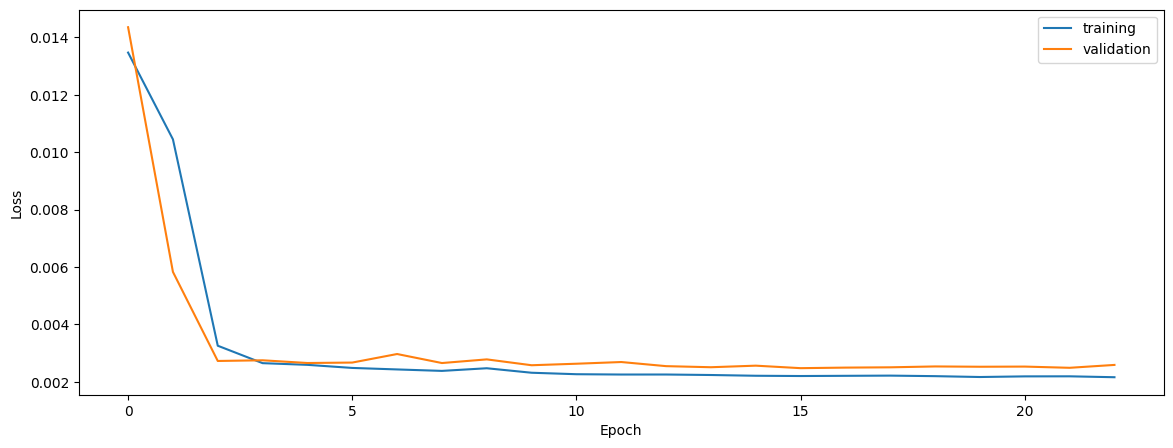

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


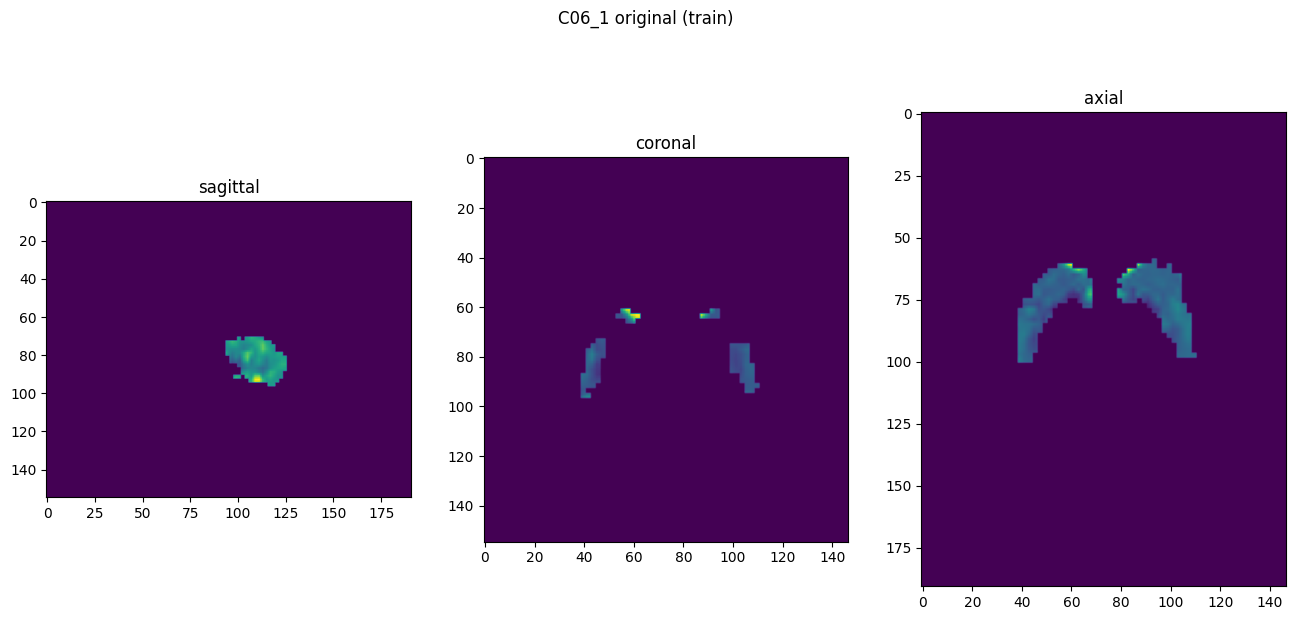

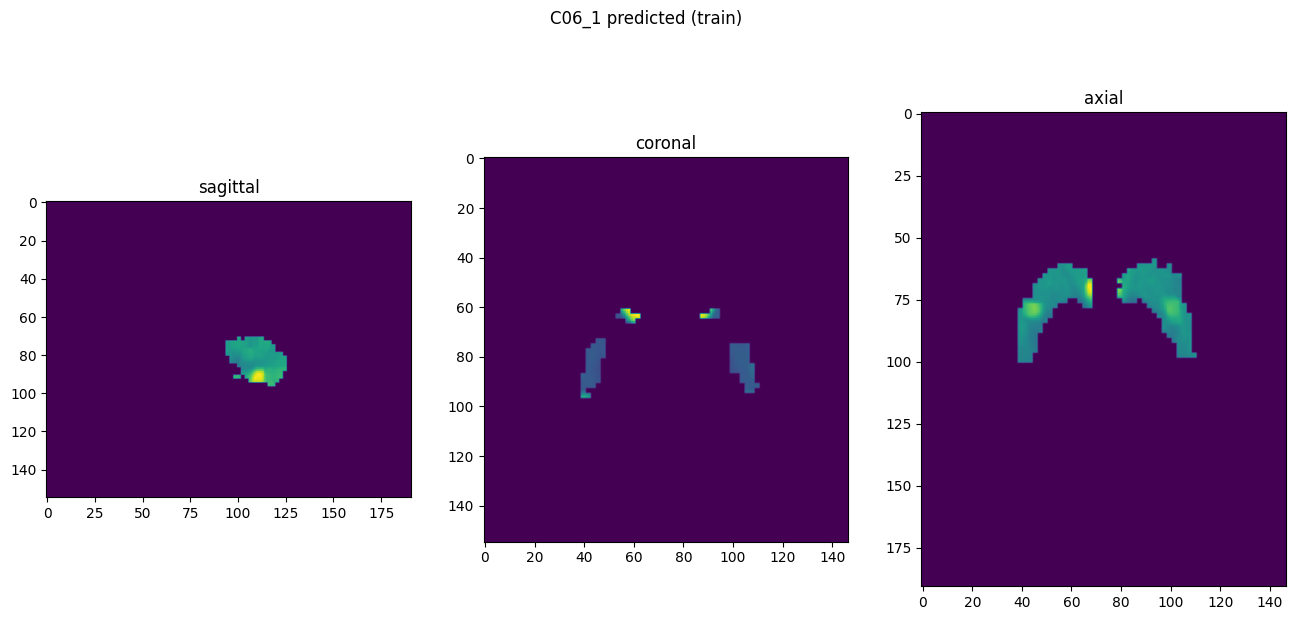

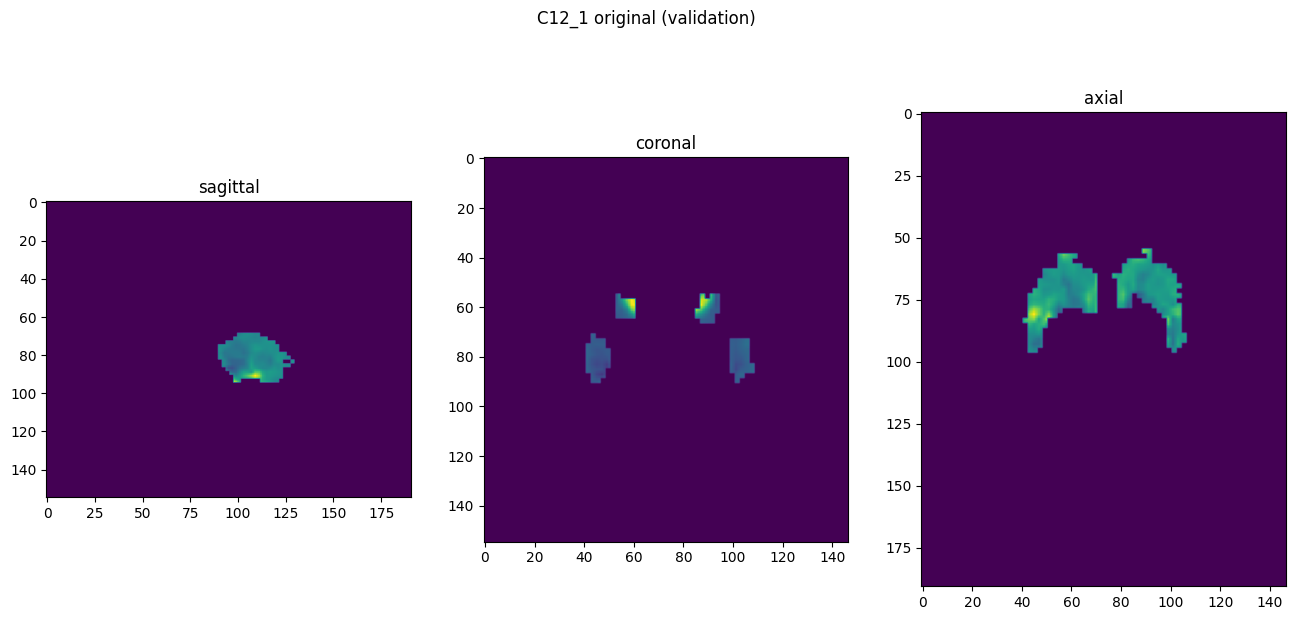

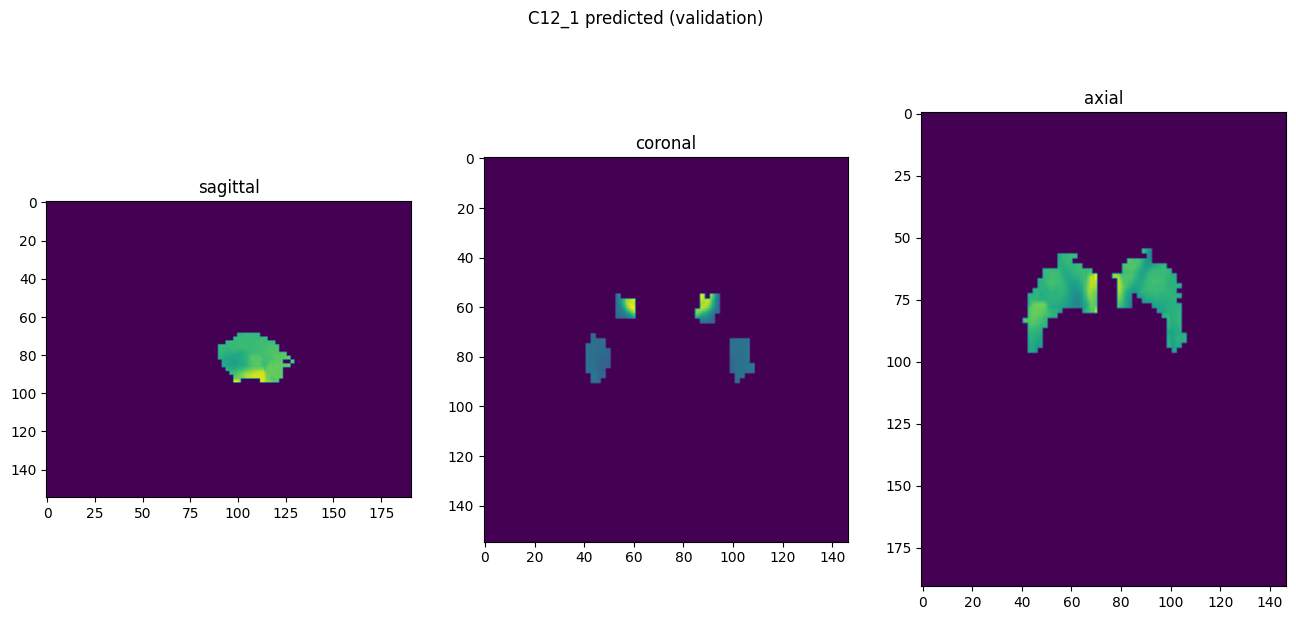

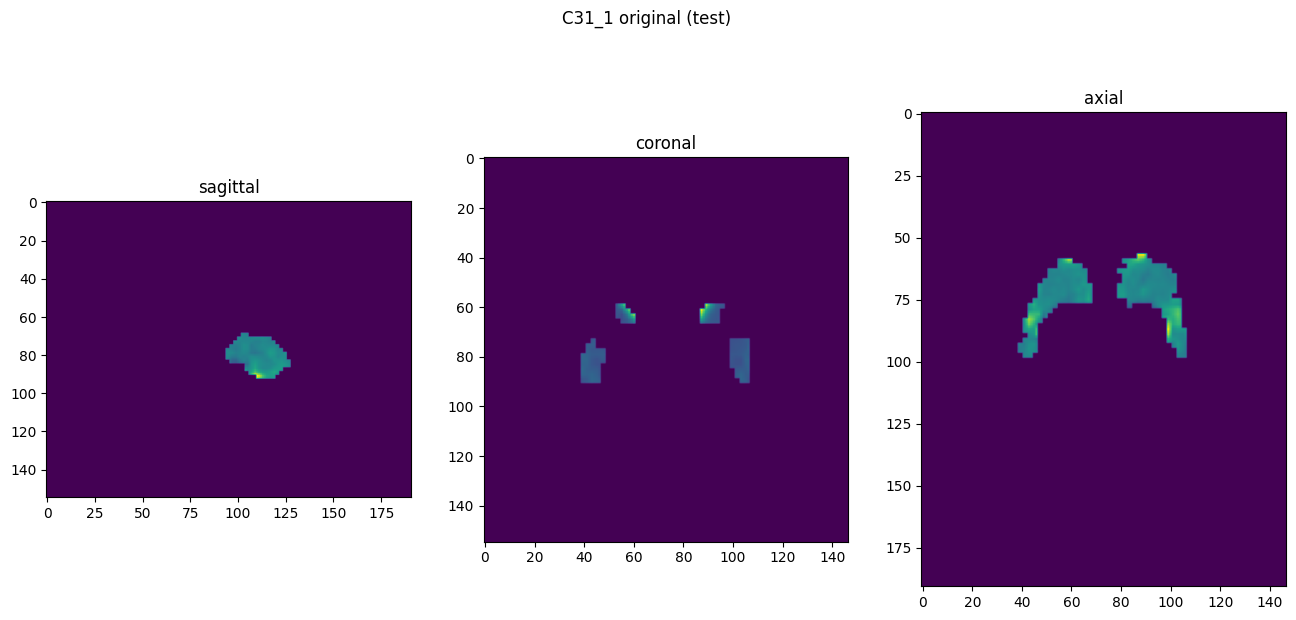

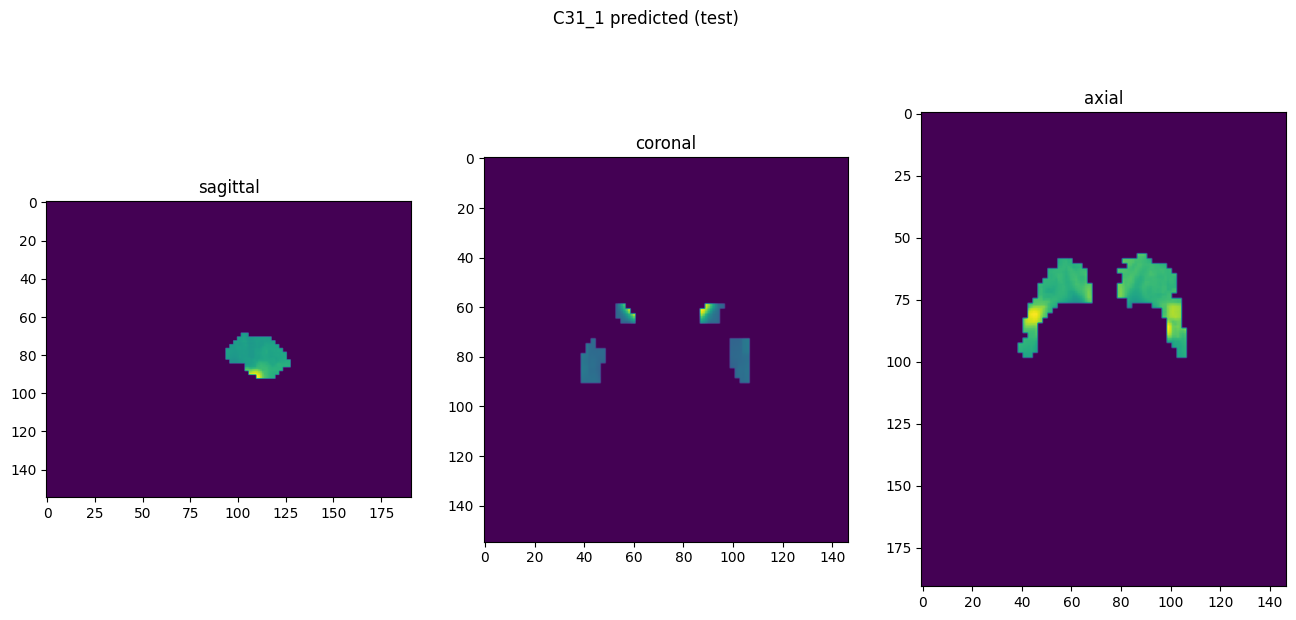

In [10]:
showResults(model, gen, threshold=None, background=False)